# Import dependencies

In [2]:
import sys
import time
from __future__ import print_function
import datetime
from torch import nn
from torch import from_numpy
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')
import string
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from collections import defaultdict

# Import data
This corpus of tweets comes from <i> Demographic Dialectal Variation in Social Media: A Case Study of African-American English. Su Lin Blodgett, Lisa Green, and Brendan O'Connor. Proceedings of EMNLP 2016. </i> <a href="https://www.aclweb.org/anthology/D16-1120/"> [pdf] </a> <a href="http://slanglab.cs.umass.edu/TwitterAAE/"> [more info] </a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
columns =["Text","AA","White"]
tweets = pd.read_csv("TwitterAAE-full-v1/twitteraae_all_aa",names=columns,delimiter="\t",nrows=100000,usecols=[5,6,9])

In [ ]:
float_check = re.compile("[0-1]\.[0-9]+$")
tweets = tweets[tweets['AA'].astype(str).str.contains(float_check)]
tweets = tweets[tweets['White'].astype(str).str.contains(float_check)]
tweets.AA = tweets.AA.astype(float)
tweets.White = tweets.White.astype(float)

In [ ]:
tweets.head()

In [ ]:
def race_count_histogram(tweets,title):
    tweets[tweets.columns[1]].hist(color='blue',alpha=.3)
    tweets[tweets.columns[2]].hist(color='orange',alpha=.3)
    handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=.2) for c in ['blue','orange']]
    labels= [tweets.columns[1],tweets.columns[2]]
    plt.title(title)
    plt.legend(handles, labels)
    plt.show()

In [ ]:
race_count_histogram(tweets,"Histogram of Proportion of Words AA/White\nCorpus: [BGO EMNLP '16]")

NameError: ignored

# Addings more tweets

The histogram above underscores the need for more tweet diversity. I used the model described in the paper above (available <a href=https://github.com/slanglab/twitteraae> here</a>) and the <a href="https://www.kaggle.com/kazanova/sentiment140/data#"> tweet corpus here </a> to enrich my list of tweets. The tweet texts and predicted classes are available in <b> race_labeled_tweets_from_sentiment.csv </b>

In [23]:
extra_tweets = pd.read_csv("/content/drive/My Drive/race_labeled_tweets_from_sentiment.csv")
extra_tweets.head()

,Text,AA,White
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0.202300,0.333193
1,is upset that he can't update his Facebook by ...,0.172174,0.583695
2,@Kenichan I dived many times for the ball. Man...,0.102774,0.730196
3,my whole body feels itchy and like its on fire,0.185610,0.390145
4,"@nationwideclass no, it's not behaving at all....",0.142938,0.457326


In [ ]:
all_tweets=tweets.append(extra_tweets).reset_index(drop=True)
all_tweets.head()

,Text,AA,White,EducationLevel,PreprocessedText
0,Click Clack Motha Fucka I ain't tryin to hear ...,0.894545,0.089091,1,click clack motha fucka aint tryin hear nothin
1,Man imissed a called from my bae hella mad -_-...,0.942000,0.000000,1,man imiss call bae hella mad
2,@devontekthomas OMG I keep sayin boo wen I mea...,0.951111,0.017778,2,omg keep sayin boo wen mean boy
3,@devontekthomas I did not mean to say dat,0.957143,0.008571,1,mean say dat
4,@devontekthomas awww u do too,0.975000,0.015000,0,awww u


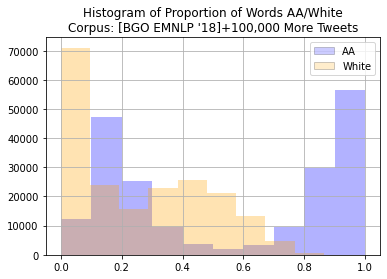

In [ ]:
race_count_histogram(all_tweets,"Histogram of Proportion of Words AA/White\nCorpus: [BGO EMNLP '18]+100,000 More Tweets")

This seems like a more reasonable mix

# Creating a biased model

Our goal is to create a bias detection engine. This notebook is designed to train a biased model that the detection engine will flag. In this case, we will train a shallow neural network that will take as input a feature vector representing the tweet. 


Then we will make a subjective judgement on the tweets. This is meant to mimic common text labeling tasks such as 
- Hate speech detection
- Education level classification
- Tweet recommendation

In this case, we will perform education level classification. We will simulate the experience of three independent labelers who label tweets according to some predetermined distribution. Since we want to produce a biased (read: <i> racist </i>) model, we will assign labels as follows:
<center>
$educlabel1(tweet) = min(8,2 \times (\mathcal{N}(tweet.AA,\,.2)\ + 6 \times \mathcal{N}(tweet.White,\,.2))$ <br>
$educlabel2(tweet) = min(8,2 \times (\mathcal{N}(tweet.AA,\,.5)\ + 6 \times \mathcal{N}(tweet.White,\,.2))$ <br>
$educlabel3(tweet) = min(8,4 \times (\mathcal{N}(tweet.AA,\,.2)\ + 4 \times \mathcal{N}(tweet.White,\,.2))$ <br>
$educlabel(tweet) = max(int(\frac{educlabel1(tweet) + educlabel2(tweet) + educlabel3(tweet)}{3}),0)$
</center>
These labelers generally give more weight to words the model in the paper above considers "White" than to words it considers "AA," thereby giving White-sounding tweets a significant advantage when it comes to education level determinations. The aggregated label does not weight lablers according to their biases.

## Test out the formula

In [ ]:
tweet = all_tweets.loc[1,:]
raw_score_1 = min(8,2*random.gauss(tweet.AA,.2) + 6*random.gauss(tweet.White,.2))
raw_score_2 = min(8,2*random.gauss(tweet.AA,.5) + 6*random.gauss(tweet.White,.2))
raw_score_3 = min(8,4*random.gauss(tweet.AA,.2) + 4*random.gauss(tweet.White,.2))
tweet_label = max(int((raw_score_1+raw_score_2+raw_score_3)/3),0)
print(tweet.Text + " : " + str(tweet_label))

Man imissed a called from my bae hella mad -_- @callme_KRAZII : 1


In [ ]:
def label(tweet):
    raw_score_1 = min(8,2*random.gauss(tweet.AA,.2) + 6*random.gauss(tweet.White,.2))
    raw_score_2 = min(8,2*random.gauss(tweet.AA,.5) + 6*random.gauss(tweet.White,.2))
    raw_score_3 = min(8,4*random.gauss(tweet.AA,.2) + 4*random.gauss(tweet.White,.2))
    return max(int((raw_score_1+raw_score_2+raw_score_3)/3),0)

In [ ]:
labels = [label(all_tweets.loc[i,:]) for i in range(len(all_tweets))]
all_tweets["EducationLevel"] = labels

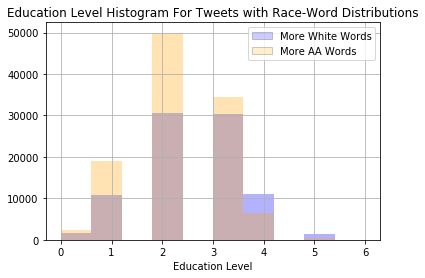

In [ ]:
all_tweets[all_tweets.White > all_tweets.AA].EducationLevel.hist(color='blue',alpha=.3)
all_tweets[all_tweets.AA > all_tweets.White].EducationLevel.hist(color='orange',alpha=.3)
handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=.2) for c in ['blue','orange']]
labels= ["More White Words","More AA Words"]
plt.title("Education Level Histogram For Tweets with Race-Word Distributions")
plt.legend(handles, labels)
plt.xlabel("Education Level")
plt.show()

This histogram shows that the lablers were in fact biased against tweets with more African American English words.

In [25]:
all_tweets.to_csv("/content/drive/My Drive/labeled_tweets.csv",index=False)

## Preprocessing


In [24]:
all_tweets = pd.read_csv("/content/drive/My Drive/labeled_tweets.csv")

### Traditional NLP Preprocessing

We will standardize case, remove stop words, mentions, and urls. We won't stem because we will be converting words to word vectors using an embedding.

In [5]:
def is_url(token):
  val = URLValidator()
  try:
      val(token)
      return True
  except ValidationError:
      return False

In [ ]:
def preprocess(tweet,stop_words=None,stemmer=None,punct_strip=None):

  # These can't be default arguments bc they come from functions
  if stop_words == None:
    stop_words = set(stopwords.words('english')) 
  if stemmer == None:
    stemmer = PorterStemmer()
  if punct_strip == None:
    punct_strip = str.maketrans('', '', string.punctuation)

  # tokenize
  tweet = tweet.split(" ")
  final_tweet = []

  for token in tweet:
    # lower case
    token = token.lower()

    # remove stop words, mentions, urls
    if token and (token in stop_words or token[0] == '@' or is_url(token)):
      continue # do not append it to final_tweet


    # remove punctuation 
    token = token.translate(punct_strip)

  
    
    if len(token) > 0:
      final_tweet.append(token)

  return " ".join(final_tweet)


  

In [ ]:
stop_words = set(stopwords.words('english')) 
punct_strip = punct_strip = str.maketrans('', '', string.punctuation)
all_tweets["PreprocessedText"] = [preprocess(t,stop_words,punct_strip) for t in all_tweets.Text]
all_tweets = all_tweets.dropna()

In [ ]:
all_tweets.PreprocessedText.head()

0    click clack motha fucka aint tryin hear nothin
1                      man imiss call bae hella mad
2                   omg keep sayin boo wen mean boy
3                                      mean say dat
4                                            awww u
Name: PreprocessedText, dtype: object

In [ ]:
all_tweets.to_csv("/content/drive/My Drive/labeled_tweets.csv",index=False)

### Dropping Rare Words

We will keep only those tokens that occur in at least five tweets. All tweets with 0 remaining tokens will be dropped.

In [ ]:
def get_unigram_frequencies(tweets):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tweets)
    return {k:v for k,v in zip(vectorizer.get_feature_names(), np.ravel(X.sum(axis=0)))}

In [ ]:
unigram_frequencies = get_unigram_frequencies(all_tweets.PreprocessedText)
keep_words = {k for k in unigram_frequencies.keys() if unigram_frequencies[k] > 4}

In [ ]:
def strip_rare_words(tweet,keep_words):
  tweet = tweet.split(" ")
  return " ".join([token for token in tweet if token in keep_words])


In [ ]:
all_tweets.PreprocessedText = [strip_rare_words(x,keep_words) for x in all_tweets.PreprocessedText]
all_tweets = all_tweets[all_tweets.PreprocessedText.str.len() > 0]

In [ ]:
len(all_tweets)

195362

### Get the size of the vocabulary

In [ ]:
vocab = set([word.strip() for x in all_tweets.PreprocessedText for word in x.split(" ")])
vocab_len = len(vocab)
print(vocab)

11722


# Prepare PyTorch Model

In [ ]:
all_tweets = pd.read_csv("/content/drive/My Drive/labeled_preprocessed_tweets.csv")

In [ ]:
all_tweets.head()

,Text,AA,White,EducationLevel,PreprocessedText
0,Click Clack Motha Fucka I ain't tryin to hear ...,0.894545,0.089091,2,click clack motha fucka aint tryin hear nothin
1,Man imissed a called from my bae hella mad -_-...,0.942000,0.000000,2,man called bae hella mad
2,@devontekthomas OMG I keep sayin boo wen I mea...,0.951111,0.017778,2,omg keep sayin boo wen mean boy
3,@devontekthomas I did not mean to say dat,0.957143,0.008571,2,mean say dat
4,@devontekthomas awww u do too,0.975000,0.015000,3,awww


### Split the dataset

In [ ]:
all_tweets = all_tweets[all_tweets.PreprocessedText.str.len()>0]
all_tweets = all_tweets[all_tweets.PreprocessedText.str.split(" ").str.len() > 1].reset_index(drop=True)
all_tweets.head()

,Text,AA,White,EducationLevel,PreprocessedText
0,Click Clack Motha Fucka I ain't tryin to hear ...,0.894545,0.089091,2,click clack motha fucka aint tryin hear nothin
1,Man imissed a called from my bae hella mad -_-...,0.942000,0.000000,2,man called bae hella mad
2,@devontekthomas OMG I keep sayin boo wen I mea...,0.951111,0.017778,2,omg keep sayin boo wen mean boy
3,@devontekthomas I did not mean to say dat,0.957143,0.008571,2,mean say dat
4,@devontekthomas wat r u doin boy,0.996000,0.004000,3,wat doin boy


In [ ]:
all_tweets["Label"] = all_tweets["EducationLevel"]>2

train_dataset = all_tweets.sample(frac = 0.6)[["PreprocessedText","Label"]]
test_indices = [i for i in range(len(all_tweets)) if i  not in train_dataset.index]
test_dataset = all_tweets.iloc[test_indices,:].reset_index(drop=True)
print("Training Data Length: " + str(len(train_dataset)))
print("Test Data Length: " + str(len(test_dataset)))

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_len = int(len(train_dataset) * 0.95)
sub_valid_ = train_dataset.sample(frac = 0.05)[["PreprocessedText","Label"]]
sub_train_indices = [i for i in range(len(train_dataset)) if i  not in sub_valid_.index]
sub_train_ = all_tweets.iloc[sub_train_indices,[4,5]].reset_index(drop=True)
sub_valid_ = sub_valid_.reset_index(drop=True)

sub_valid_.to_csv("/content/drive/My Drive/PyTorchData/validate.csv",index=False)
sub_train_ = all_tweets.iloc[sub_train_indices,[4,5]].reset_index(drop=True)
sub_train_.to_csv("/content/drive/My Drive/PyTorchData/train.csv",index=False)
test_dataset.to_csv("/content/drive/My Drive/PyTorchData/test.csv",index=False)

Training Data Length: 107800
Test Data Length: 71866


In [7]:
sub_valid_ = pd.read_csv("/content/drive/My Drive/PyTorchData/validate.csv")
sub_train_ = pd.read_csv("/content/drive/My Drive/PyTorchData/train.csv")
test_dataset = pd.read_csv("/content/drive/My Drive/PyTorchData/test.csv")

In [8]:
sub_train_.head()

,PreprocessedText,Label
0,click clack motha fucka aint tryin hear nothin,False
1,man called bae hella mad,False
2,mean say dat,False
3,wat doin boy,True
4,know dats rite,True


### Turn the text into tensors

In [9]:
from torchtext import data    
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
train_data=data.TabularDataset(path = '/content/drive/My Drive/PyTorchData/train.csv',format = 'csv',fields = fields,skip_header = True)
valid_data=data.TabularDataset(path = '/content/drive/My Drive/PyTorchData/validate.csv',format = 'csv',fields = fields,skip_header = True)
TEXT.build_vocab(train_data,min_freq=0,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

print(TEXT.vocab.stoi)  

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                          
100%|█████████▉| 398525/400000 [00:22<00:00, 18097.81it/s]

defaultdict(<function _default_unk_index at 0x7f86ca7e92f0>, {'<unk>': 0, '<pad>': 1, 'i': 2, 'm': 3, 'nt': 4, 'lol': 5, 'got': 6, 'get': 7, 'like': 8, 'go': 9, 'shit': 10, 'ca': 11, 'good': 12, 's': 13, 'love': 14, 'amp': 15, 'know': 16, 'ai': 17, 'ass': 18, 'need': 19, 'back': 20, 'day': 21, 'want': 22, 'time': 23, 'fuck': 24, 'nigga': 25, 'that': 26, 'work': 27, 'going': 28, 'still': 29, 'today': 30, 'one': 31, 'see': 32, 'bitch': 33, 'really': 34, 'do': 35, 'da': 36, 'think': 37, 'sleep': 38, 'wanna': 39, 'yo': 40, 'bout': 41, 'ta': 42, 'damn': 43, 'feel': 44, 'right': 45, 'say': 46, 'make': 47, 'me': 48, 'man': 49, 'gone': 50, 'all': 51, 'night': 52, 'wit': 53, 'new': 54, 'hate': 55, 'last': 56, 'home': 57, 'well': 58, 'niggas': 59, 'much': 60, 'bad': 61, 'morning': 62, 'miss': 63, 'never': 64, 'school': 65, 'come': 66, 'oh': 67, 'y': 68, 'lmao': 69, 'tho': 70, 'people': 71, 'even': 72, 'dat': 73, 'twitter': 74, 'ill': 75, 'would': 76, 'it': 77, 'real': 78, 'take': 79, 'girl': 80,

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

## Define the Model Class - 

Following code from <a href="https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/">here. </a> Using an LSTM.


In [11]:
class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

## Instantiate the model

In [12]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)
print(model)

classifier(
  (embedding): Embedding(13903, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

The model has 1,449,757 trainable parameters
torch.Size([13903, 100])


## Define functions that train the model

In [14]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [15]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Train the model
Code inspired by this page: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

In [17]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.670 | Train Acc: 60.13%
	 Val. Loss: 0.655 |  Val. Acc: 62.16%
	Train Loss: 0.654 | Train Acc: 62.36%
	 Val. Loss: 0.636 |  Val. Acc: 64.22%
	Train Loss: 0.630 | Train Acc: 64.79%
	 Val. Loss: 0.628 |  Val. Acc: 64.66%
	Train Loss: 0.599 | Train Acc: 67.09%
	 Val. Loss: 0.618 |  Val. Acc: 66.83%
	Train Loss: 0.562 | Train Acc: 69.51%
	 Val. Loss: 0.628 |  Val. Acc: 67.89%


# See the model's predictions

We now have a trained model saved in saved_weights.pt. We will apply it to the test set. Remember, we are not worried about accuracy in the traditional sense. For our purposes we just want to make sure this model is biased against AA-english words.

In [18]:
#load weights
path='/content/saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction[0].item()

In [19]:
small_tweets = test_dataset.sample(frac=.1).reset_index(drop=True)
small_tweets["Prediction"] = [predict(model,small_tweets.PreprocessedText[i]) for i in range(len(small_tweets))]

In [20]:
small_tweets.head()

,Text,AA,White,EducationLevel,PreprocessedText,Label,Prediction
0,@yo_mf_momma get to see my sorry ahh boys play...,0.923077,0.070769,3,get see sorry ahh boys play even trey lol,True,0.575044
1,Loads of housework and getting ready for my da...,0.184490,0.584876,4,loads housework getting ready daughter returni...,True,0.971335
2,Put thaa purp in tha blunt ........west$idee w...,0.886667,0.108333,2,put thaa purp tha blunt,False,0.042253
3,Own None of my parcels arrived today! Annoyin...,0.273368,0.321779,2,none arrived today annoying,False,0.759729
4,I hope all those bad things weren't about me,0.123920,0.465548,3,hope bad things,True,0.394998


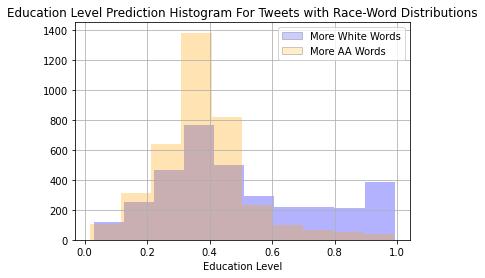

In [21]:
small_tweets[small_tweets.White > small_tweets.AA].Prediction.hist(color='blue',alpha=.3)
small_tweets[small_tweets.AA > small_tweets.White].Prediction.hist(color='orange',alpha=.3)
handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=.2) for c in ['blue','orange']]
labels= ["More White Words","More AA Words"]
plt.title("Education Level Prediction Histogram For Tweets with Race-Word Distributions")
plt.legend(handles, labels)
plt.xlabel("Education Level")
plt.show()

We have the result we wanted